In [1]:
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import requests
import PIL
import io

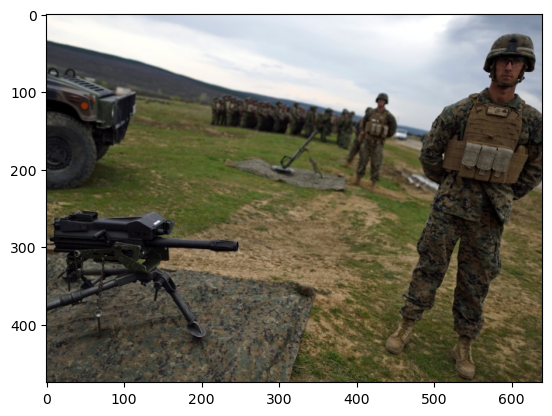

In [12]:
#Load image from Internet-URL
#url = "https://www.dogbreedinfo.com/images32/GermanShepherdAdultDogLayInGrassOutside.jpg"
#url = "https://www.aerotime.aero/images/us_navy_f-18_super_hornet.jpg"
url = "https://balkaninsight.com/wp-content/uploads/2018/08/640-novo-selo.jpg"
response = requests.get(url)
image_bytes = io.BytesIO(response.content)
img = PIL.Image.open(image_bytes)

plt.imshow(img)

In [13]:
"""
data transforms, for pre-processing the input testing image before feeding into the net
"""
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),             # resize the input to 224x224
    transforms.ToTensor(),              # put the input to tensor format
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the input
    # the normalization is based on images from ImageNet
])

print("Original image shape: " + str(img.size))
# pre-process the input
transformed_img = data_transforms(img)
print("Transformed image shape: " + str(transformed_img.shape))
# form a batch with only one image
batch_img = torch.unsqueeze(transformed_img, 0)
print("Batch of images shape: " + str(batch_img.shape))

Original image shape: (640, 475)
Transformed image shape: torch.Size([3, 224, 224])
Batch of images shape: torch.Size([1, 3, 224, 224])


In [5]:
# load pre-trained AlexNet model
print("Set up pre-trained AlexNet network")
net = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
# Set network to "evaluation" mode, evalute image
net.eval()
output = net(batch_img)

#Map the class no. to the corresponding label
with open('class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

#Sort the probability vector in descending order
sorted, indices = torch.sort(output, descending=True)
percentage = F.softmax(output, dim=1)[0] * 100.0
#Show top 5 classes (highest probability) for input
results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
print("Print top 5 classes for test image:\n")
for i in range(5):
    print('{}: {:.4f}%'.format(results[i][0], results[i][1]))


Set up pre-trained AlexNet network
Print top 5 classes for test image:

German shepherd, German shepherd dog, German police dog, alsatian: 91.8554%
keeshond: 7.0221%
Norwegian elkhound, elkhound: 0.2964%
malamute, malemute, Alaskan malamute: 0.2420%
muzzle: 0.2047%


In [6]:
net = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
net.eval()
output = net(batch_img)
#Sort the probability vector in descending order
sorted, indices = torch.sort(output, descending=True)
percentage = F.softmax(output, dim=1)[0] * 100.0
#Show top 5 classes (highest probability) for input
results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
print("Print top 5 classes for test image:\n")
for i in range(5):
    print('{}: {:.4f}%'.format(results[i][0], results[i][1]))


Print top 5 classes for test image:

German shepherd, German shepherd dog, German police dog, alsatian: 99.5266%
keeshond: 0.1355%
bulletproof vest: 0.0927%
briard: 0.0635%
Norwegian elkhound, elkhound: 0.0487%


In [14]:
# load pre-trained segmentation model
print("Set up pre-trained FCN_ResNet101 network")
net = models.segmentation.fcn_resnet101(weights=models.segmentation.FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
net = net.eval()

#Per-class prediction for each pixel position, 21 "color"-channels
output = net(batch_img)['out']

output_argmax = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()

Set up pre-trained FCN_ResNet101 network


In [15]:
#Helper function for converting class-maps to rgb-representation
def decode_segmap(image, nc=21):
    my_label_colors = np.array([(0, 0, 0),  # 0=background
        # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
        (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
        # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
        (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
        # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
        (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
        # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
        (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
    ])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = my_label_colors[l, 0]
        g[idx] = my_label_colors[l, 1]
        b[idx] = my_label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

label_dict = {0:'background', 1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle',
              6:'bus', 7:'car', 8:'cat', 9:'chair', 10:'cow',
              11:'dining table', 12:'dog', 13:'horse', 14:'motorbike', 15:'person',
              16:'potted plant', 17:'sheep', 18:'sofa', 19:'train', 20:'tv/monitor',
             }

['background', 'bicycle', 'car', 'person']


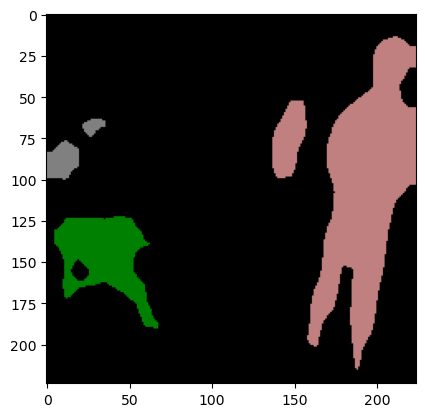

In [16]:
output_rgb = decode_segmap(output_argmax)
print([label_dict[i] for i in np.unique(output_argmax)])
plt.imshow(output_rgb)